# Routing

Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

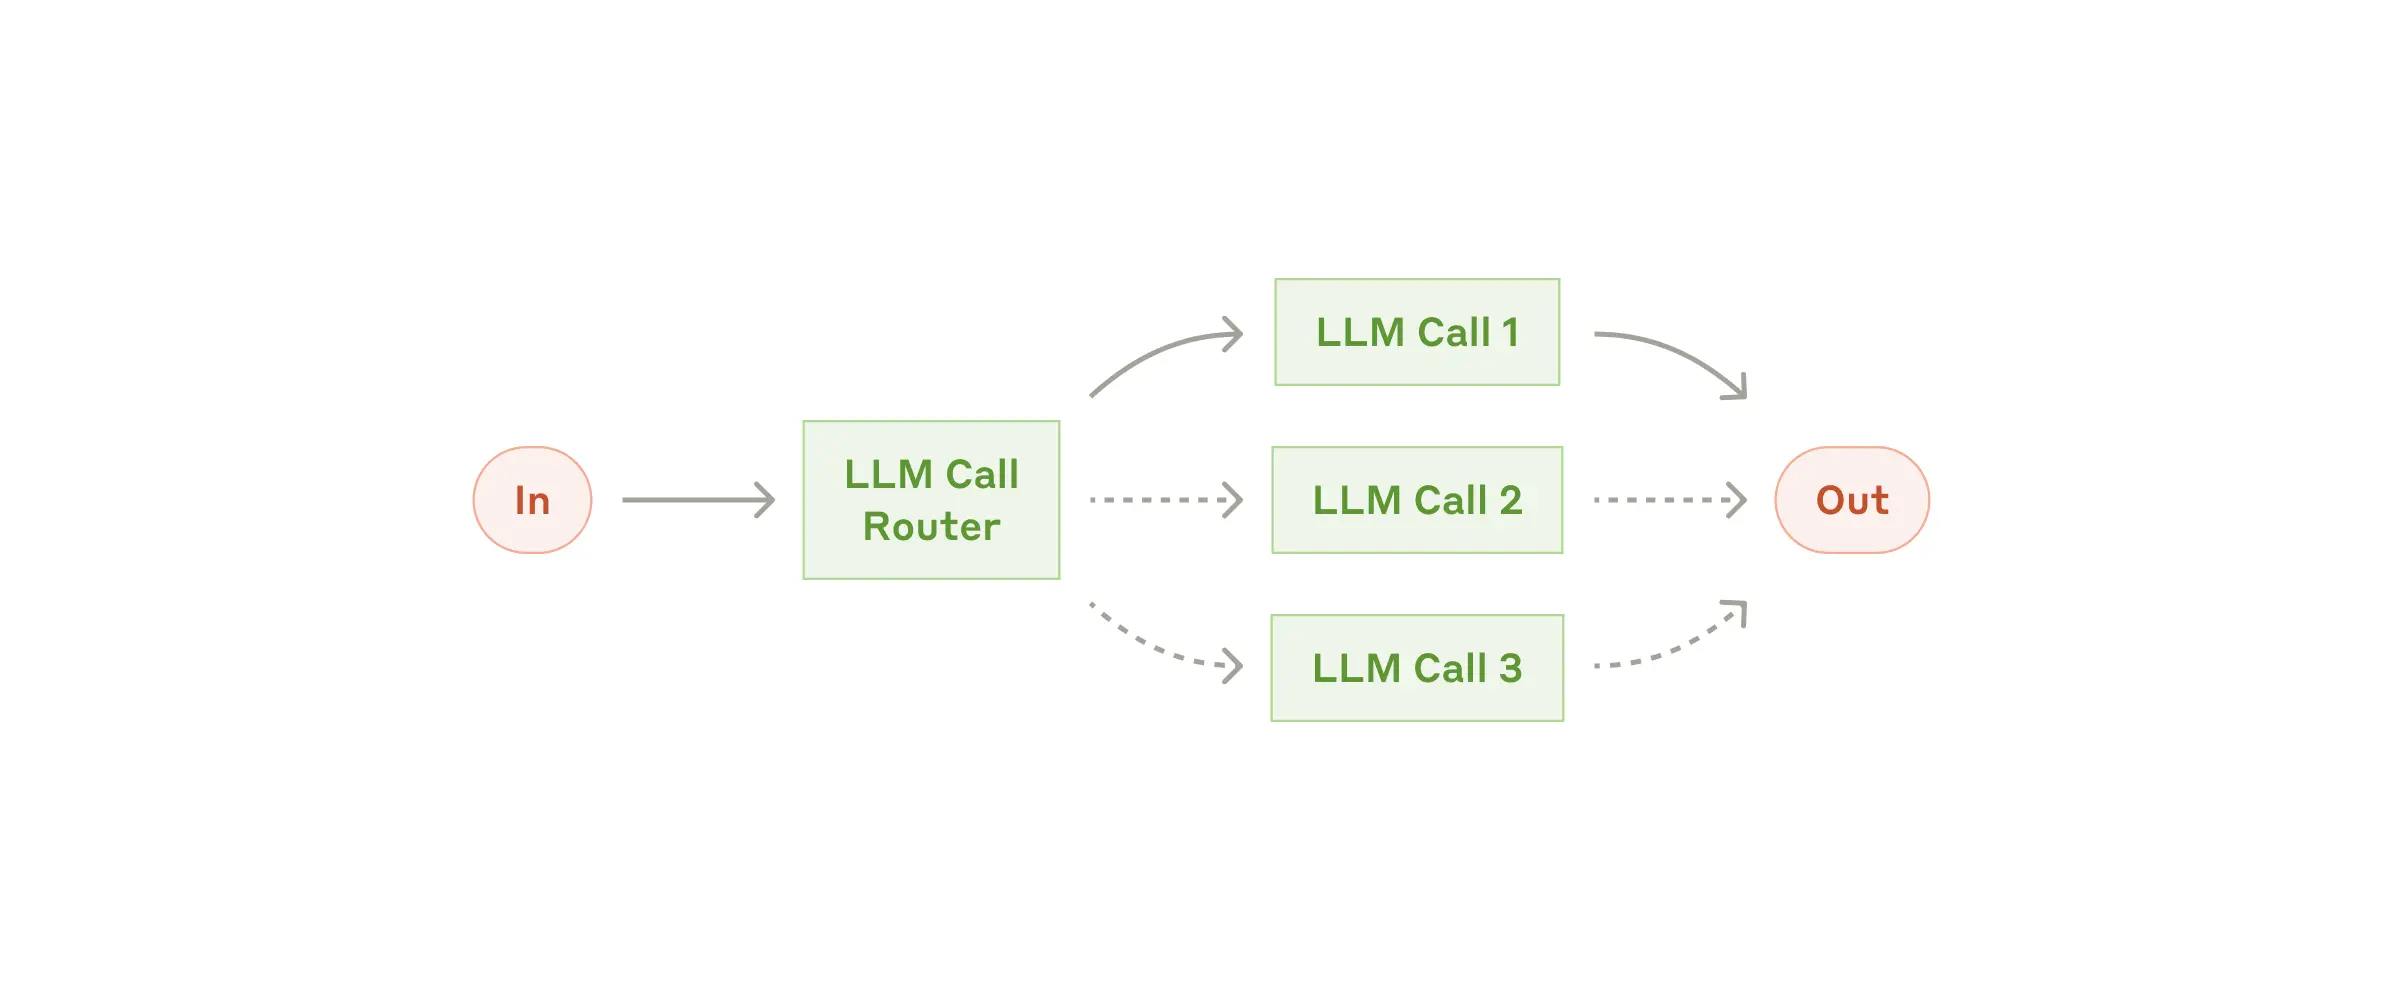

**When to use this workflow:** Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

## Install Packages

In [10]:
!pip install -Uq openai-agents

In [11]:
import nest_asyncio
nest_asyncio.apply()

## Config

In [12]:
from agents import (
    AsyncOpenAI,
    OpenAIChatCompletionsModel
)
from google.colab import userdata


In [13]:
gemini_api_key = userdata.get("GEMINI_API_KEY")


# Check if the API key is present; if not, raise an error
if not gemini_api_key:
    raise ValueError("GEMINI_API_KEY is not set. Please ensure it is defined in your .env file.")

#Reference: https://ai.google.dev/gemini-api/docs/openai
external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

In [14]:
from agents import set_default_openai_client, set_tracing_disabled
set_default_openai_client(external_client)
set_tracing_disabled(True)

## Implement Routing Pattern

This shows the routing. The triage agent receives the first message, and
then hands off to the appropriate agent based on the language of the request. Responses are
streamed to the user.

------------------------------------------------

In [18]:
import asyncio
import uuid

from openai.types.responses import ResponseContentPartDoneEvent, ResponseTextDeltaEvent

from agents import Agent, RawResponsesStreamEvent, Runner, TResponseInputItem, trace

french_agent = Agent(
    name="french_agent",
    instructions="You only speak French",
    model=model
)

spanish_agent = Agent(
    name="spanish_agent",
    instructions="You only speak Spanish",
    model=model
)

english_agent = Agent(
    name="english_agent",
    instructions="You only speak English",
    model=model
)

triage_agent = Agent(
    name="triage_agent",
    instructions="Handoff to the appropriate agent based on the language of the request.",
    handoffs=[french_agent, spanish_agent, english_agent],
    model=model
)

In [23]:
async def main():
    msg = input("Hi! We speak French, Spanish and English. How can I help? ")
    agent = triage_agent
    inputs: list[TResponseInputItem] = [{"content": msg, "role": "user"}]

    while True:
        # Each conversation turn is a single trace. Normally, each input from the user would be an
        # API request to your app, and you can wrap the request in a trace()
        result = Runner.run_streamed(
            agent,
            input=inputs,
        )
        async for event in result.stream_events():
            if not isinstance(event, RawResponsesStreamEvent):
                continue
            data = event.data
            if isinstance(data, ResponseTextDeltaEvent):
                print(data.delta, end="", flush=True)
            elif isinstance(data, ResponseContentPartDoneEvent):
                print("\n")

        inputs = result.to_input_list()
        print("\n")

        user_msg = input("Enter a message: ")
        if user_msg == "exit":
          break
        inputs.append({"content": user_msg, "role": "user"})
        agent = result.current_agent

In [24]:
asyncio.run(main())

Hi! We speak French, Spanish and English. How can I help? I want to book a flight
Okay, I can help you with that!  To find the best flight for you, I need some information.  Please tell me:

*   **Where are you flying from?** (Departure city/airport)
*   **Where are you flying to?** (Destination city/airport)
*   **What date would you like to depart?**
*   **What date would you like to return?** (If it's a round trip)
*   **How many passengers?** (Adults, children, infants)
*   **Do you have any preferred airlines?**
*   **Do you have any preferred class of service?** (Economy, Business, First Class)
*   **Do you have a maximum budget?** (Optional, but helpful)




Enter a message: Hmmm
Is there something I can clarify or help you with? Are you unsure about any of the information I requested? Just let me know!




Enter a message: exit
